In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
try:
    import open3d as o3d
except ImportError:
    import sys
    print(sys.exc_info())
import pandas as pd
from scipy import interpolate
import quadpy

from dosipy.utils.integrate import elementwise_dblquad

In [2]:
def v(t, s):
    """Parametric surface in 3-D:
    v(t, s) = (t + 1) i + (s) j + (s^2 - t^2 + 1) k
    """
    return np.c_[t + 1,
                 s,
                 s ** 2 - t ** 2 + 1]

In [3]:
# integration domain
t = [-2, 2]
s = [-2, 2]

# integration points
roots, weights = np.polynomial.legendre.leggauss(40)
tx = 0.5 * (roots + 1.) * (t[1] - t[0]) + t[0]
tw = 0.5 * weights * (t[1] - t[0])
sx = 0.5 * (roots + 1.) * (s[1] - s[0]) + s[0]
sw = 0.5 * weights * (s[1] - s[0])
T, S = np.meshgrid(tx, sx)
TW, SW = np.meshgrid(tw, sw)
V = v(T.ravel(), S.ravel())

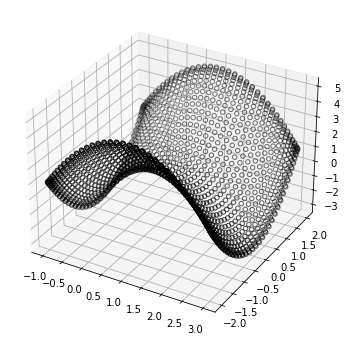

In [4]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(*V.T, ec='k', c='None');

In [68]:
# conversion to point cloud object and estimating normals
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(V)
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=5, max_nn=10))
pcd.orient_normals_consistent_tangent_plane(10)
n = np.asarray(pcd.normals)
# o3d.visualization.draw_geometries([pcd], point_show_normal=True)

In [69]:
def F(x, y, z):
    """Vector field that passes through V(t, s):
    F(x, y, z) = i + j + k
    """
    return np.c_[np.ones_like(x),
                 np.ones_like(y),
                 np.ones_like(z)]

In [73]:
points = np.c_[T.ravel(), S.ravel()]  # 2-D set of points
values = np.sum(F(*V.T) * n, axis=1)  # integrand = F(V(t, s)) · n(x, y, z)
I_exact = 5.65473

In [74]:
I_approx = elementwise_dblquad(points, values, 
                               degree=11,
                               interp_func=interpolate.CloughTocher2DInterpolator
                               )

In [75]:
scheme = quadpy.c2.get_good_scheme(21)
func = interpolate.CloughTocher2DInterpolator(points, values)
I_approx2 = scheme.integrate(f=lambda x: func(x[0], x[1]),
                             ncube=quadpy.c2.rectangle_points(t, s))